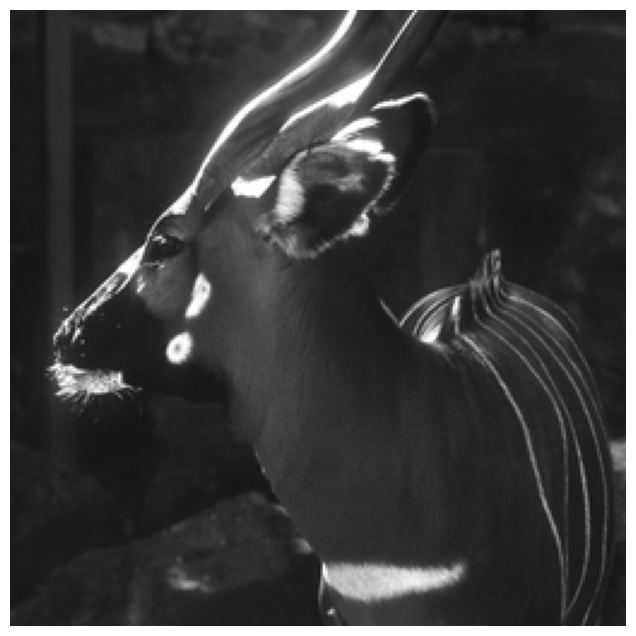

In [25]:
# 8 bit grey scale deer.png, a image taken from https://imagecompression.info/test_images/
# load deer.png with matplotlib and resize to 256*256
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np

# Load the image
img = mpimg.imread('deer.png')

# Convert to PIL Image for resizing
pil_img = Image.fromarray(np.uint8(img * 255) if img.max() <= 1 else img)

# Resize to 256x256
resized_img = pil_img.resize((256, 256), Image.Resampling.LANCZOS)

# Convert back to numpy array for matplotlib
resized_array = np.array(resized_img)

# Display the resized image
plt.figure(figsize=(8, 8))
plt.imshow(resized_array)
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.image as mpimg
from PIL import Image

def angular_spectrum_propagation(E0, wavelength, z, xmax, N, padding_pixels=0):
    """Calculate electric field propagation with optional padding, returning both padded and cropped fields"""
    # If padding is requested, extend the field
    if padding_pixels > 0:
        N_padded = N + 2 * padding_pixels
        E0_padded = np.zeros((N_padded, N_padded), dtype=complex)
        start_idx = padding_pixels
        end_idx = padding_pixels + N
        E0_padded[start_idx:end_idx, start_idx:end_idx] = E0
        input_field = E0_padded
        total_N = N_padded
        total_xmax = xmax * (N_padded / N)  # Adjust domain size proportionally
    else:
        input_field = E0
        total_N = N
        total_xmax = xmax
    
    # Propagation
    dx = 2 * total_xmax / total_N
    x = np.linspace(-total_xmax, total_xmax, total_N, endpoint=False)
    X, Y = np.meshgrid(x, x)
    
    k = 2 * np.pi / wavelength
    fx = np.fft.fftfreq(total_N, dx)
    FX, FY = np.meshgrid(fx, fx)
    
    kx = 2 * np.pi * FX
    ky = 2 * np.pi * FY
    kz = np.sqrt(k**2 - kx**2 - ky**2)
    kz = np.real(kz) * (kz.imag == 0)  # Avoid complex values outside evanescent region
    H = np.exp(1j * kz * z)
    H[kx**2 + ky**2 > k**2] = 0  # Set evanescent waves to zero
    
    U0 = fft2(input_field)  # No fftshift needed with fftfreq
    U = U0 * H
    E = ifft2(U)
    
    # Calculate amplitude and phase for padded field
    mag_padded = np.abs(E)
    phase_padded = np.angle(E)
    
    # Coordinates for padded field
    X_padded = X
    Y_padded = Y
    
    # Remove padding from the output if it was applied
    if padding_pixels > 0:
        mag_cropped = mag_padded[start_idx:end_idx, start_idx:end_idx]
        phase_cropped = phase_padded[start_idx:end_idx, start_idx:end_idx]
        X_cropped = X[start_idx:end_idx, start_idx:end_idx]
        Y_cropped = Y[start_idx:end_idx, start_idx:end_idx]
    else:
        mag_cropped = mag_padded
        phase_cropped = phase_padded
        X_cropped = X
        Y_cropped = Y
    
    return (mag_padded, phase_padded, X_padded, Y_padded), (mag_cropped, phase_cropped, X_cropped, Y_cropped)

def propagate_field(padding_pixels, resized_array):
    # Parameters
    lambda_ = 633e-9  # wavelength in meters (633 nm)
    xmax = 2e-2       # 2 cm in meters (field width)
    z = 500e-3        # propagation distance 500 mm in meters
    N = 256           # image size (256x256)

    # Convert to 2D array and set as amplitude
    if resized_array.ndim == 3:
        field = np.mean(resized_array, axis=2)  # Average color channels if RGB
    else:
        field = resized_array

    field = field.astype(np.float64)

    # Normalize field to maximum amplitude of 1
    field = field / np.max(field)

    # Initial phase (flat, set to 0)
    phase = np.zeros((N, N))
    u0 = field * np.exp(1j * phase)  # complex field

    # Calculate initial amplitude and phase
    amplitude0 = np.abs(u0)
    phase0 = np.angle(u0)

    # Propagate the field
    (mag_padded, phase_padded, X_padded, Y_padded), (mag_cropped, phase_cropped, X_cropped, Y_cropped) = \
        angular_spectrum_propagation(u0, lambda_, z, xmax, N, padding_pixels)

    # Plot results
    plt.figure(figsize=(12, 10))

    # Initial field (z = 0)
    plt.subplot(221)
    plt.imshow(amplitude0, extent=[-xmax, xmax, -xmax, xmax])
    plt.title('Amplitude at z = 0 m')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.colorbar(label='Amplitude')

    plt.subplot(222)
    plt.imshow(phase0, extent=[-xmax, xmax, -xmax, xmax], cmap='hsv')
    plt.title('Phase at z = 0 m')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.colorbar(label='Phase (radians)')

    # Propagated field (z = 500 mm, cropped)
    plt.subplot(223)
    plt.imshow(mag_cropped, extent=[-xmax, xmax, -xmax, xmax])
    plt.title('Amplitude at z = 0.500 m (Cropped)')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.colorbar(label='Amplitude')

    plt.subplot(224)
    plt.imshow(phase_cropped, extent=[-xmax, xmax, -xmax, xmax], cmap='hsv')
    plt.title('Phase at z = 0.500 m (Cropped)')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.colorbar(label='Phase (radians)')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("At z = 0 mm:")
    print(f"Max amplitude: {np.max(amplitude0):.3f}")
    print(f"Min amplitude: {np.min(amplitude0):.3f}")
    print(f"Phase range: {np.min(phase0):.3f} to {np.max(phase0):.3f} radians")
    print("\nAt z = 500 mm (Cropped):")
    print(f"Max amplitude: {np.max(mag_cropped):.3f}")
    print(f"Min amplitude: {np.min(mag_cropped):.3f}")
    print(f"Phase range: {np.min(phase_cropped):.3f} to {np.max(phase_cropped):.3f} radians")

        # Plot 1: 2D Output Field Magnitude (Padded vs Cropped)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    im1 = ax1.imshow(mag_padded, extent=[-xmax * (mag_padded.shape[1] / N), xmax * (mag_padded.shape[1] / N),
                                         -xmax * (mag_padded.shape[0] / N), xmax * (mag_padded.shape[0] / N)], cmap='viridis')
    ax1.set_title(f'Padded Field at z = {z} m\n({padding_pixels} pixels padding)')
    ax1.set_xlabel('x (m)')
    ax1.set_ylabel('y (m)')
    plt.colorbar(im1, ax=ax1, label='Magnitude')
    
    im2 = ax2.imshow(mag_cropped, extent=[-xmax, xmax, -xmax, xmax], cmap='viridis')
    ax2.set_title(f'Cropped Field at z = {z} m\n({padding_pixels} pixels padding)')
    ax2.set_xlabel('x (m)')
    ax2.set_ylabel('y (m)')
    plt.colorbar(im2, ax=ax2, label='Magnitude')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Load the image
    img = mpimg.imread('deer.png')
    
    # Convert to PIL Image for resizing
    pil_img = Image.fromarray(np.uint8(img * 255) if img.max() <= 1 else img)
    
    # Resize to 256x256
    resized_array = np.array(pil_img.resize((256, 256), Image.Resampling.LANCZOS))

    # Padding calculation
    N = 256
    xmax = 2e-2  # 2 cm
    dx = xmax / N  # Grid spacing: ~7.8125e-5 m per pixel
    desired_padding_pixels_per_side = 256  # 256 pixels per side
    padding_distance_per_side = dx * desired_padding_pixels_per_side  # ~0.02 m per side
    print(f"Padded extra {padding_distance_per_side*100:.3f} cm per side ({desired_padding_pixels_per_side} pixels)")
    
    # Run propagation
    propagate_field(padding_pixels=desired_padding_pixels_per_side, resized_array=resized_array)

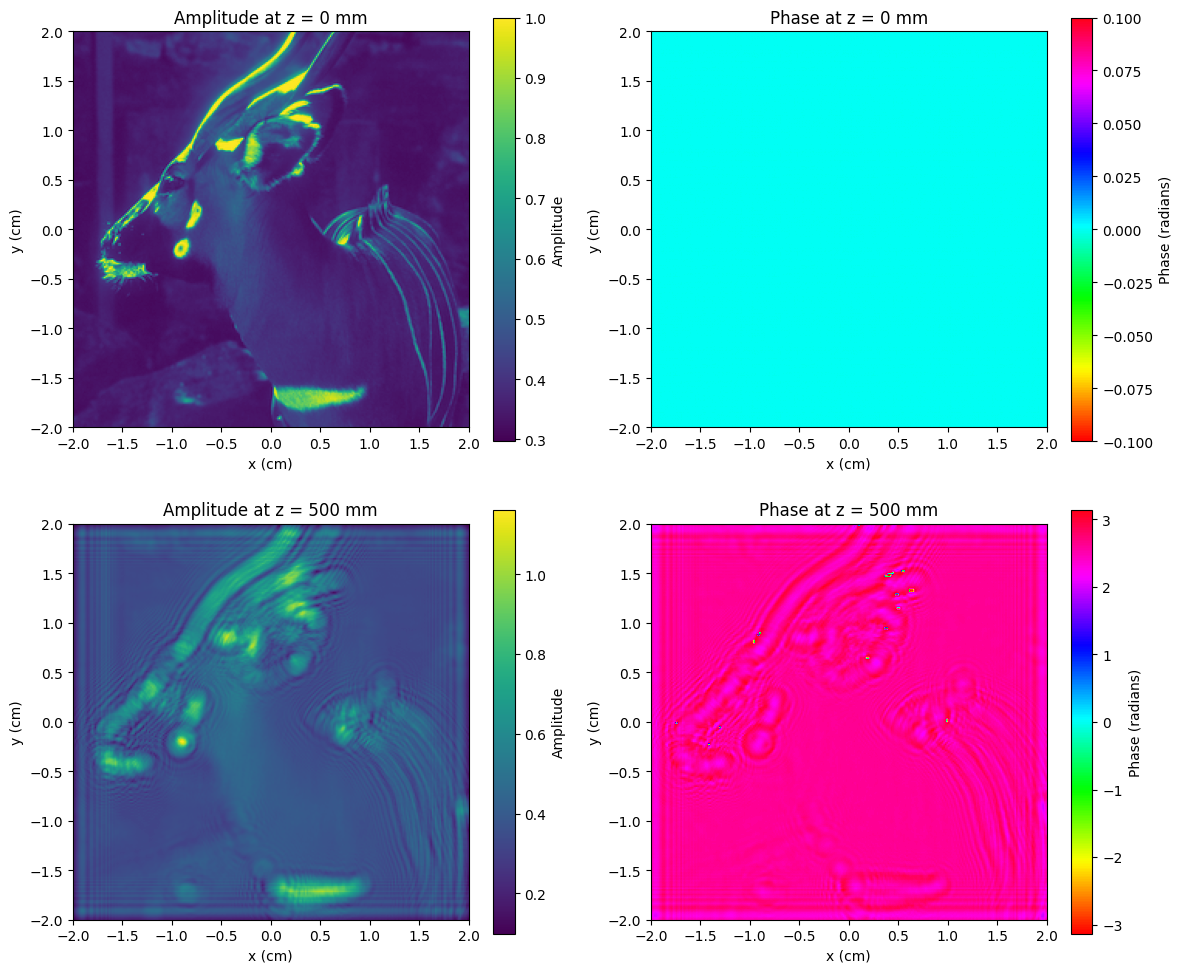

At z = 0 mm:
Max amplitude: 1.000
Min amplitude: 0.297
Phase range: 0.000 to 0.000 radians

At z = 500 mm:
Max amplitude: 1.161
Min amplitude: 0.099
Phase range: -3.135 to 3.140 radians


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift

def propagate_field():
    # Parameters
    lambda_ = 633e-9  # wavelength in meters (633 nm)
    xmax = 2e-2       # 2 cm in meters
    z = 500e-3        # propagation distance 500 mm in meters
    N = 256           # image size (512x512)
    dx = xmax/N       # pixel size in meters

    # Load and prepare initial field (assuming resized_array from previous context)
    # For this example, we'll create a simple field if resized_array isn't defined
    try:
        field = np.mean(resized_array, axis=2) if resized_array.ndim == 3 else resized_array
    except NameError:
        # Create a simple circular aperture as fallback
        x = np.linspace(-xmax, xmax, N)
        X, Y = np.meshgrid(x, x)
        field = np.zeros((N, N))
        field[np.sqrt(X**2 + Y**2) < xmax/4] = 1.0

    field = field.astype(np.float64)

    # Normalize field to maximum amplitude of 1
    field = field / np.max(field)

    # Initial phase (flat, set to 0)
    phase = np.zeros((N, N))
    u0 = field * np.exp(1j * phase)  # complex field

    # Calculate initial amplitude and phase
    amplitude0 = np.abs(u0)
    phase0 = np.angle(u0)

    # Pad the field to avoid edge artifacts (2x padding)
    pad_size = N
    u0_padded = np.pad(u0, ((pad_size, pad_size), (pad_size, pad_size)), mode='constant')

    # Spatial coordinates
    N_padded = N + 2 * pad_size
    x = np.linspace(-xmax, xmax, N_padded)
    X, Y = np.meshgrid(x, x)
    kx = 2 * np.pi * np.linspace(-1/(2*dx), 1/(2*dx), N_padded)
    KX, KY = np.meshgrid(kx, kx)

    # Propagation in Fourier domain (Angular Spectrum Method)
    k = 2 * np.pi / lambda_
    kz = np.sqrt(k**2 - KX**2 - KY**2)
    kz = np.real(kz) * (kz.imag == 0)  # avoid complex values outside evanescent region
    H = np.exp(1j * kz * z)  # transfer function

    # FFT of initial field
    U0 = fftshift(fft2(u0_padded))

    # Propagate field
    U1 = U0 * H

    # Inverse FFT to get propagated field
    u1_padded = ifft2(ifftshift(U1))

    # Crop back to original size
    u1 = u1_padded[pad_size:pad_size+N, pad_size:pad_size+N]

    # Calculate propagated amplitude and phase
    amplitude1 = np.abs(u1)
    phase1 = np.angle(u1)

    # Plot results
    plt.figure(figsize=(12, 10))

    # Initial field (z = 0)
    plt.subplot(221)
    plt.imshow(amplitude0, extent=[-xmax*100, xmax*100, -xmax*100, xmax*100])
    plt.title('Amplitude at z = 0 mm')
    plt.xlabel('x (cm)')
    plt.ylabel('y (cm)')
    plt.colorbar(label='Amplitude')

    plt.subplot(222)
    plt.imshow(phase0, extent=[-xmax*100, xmax*100, -xmax*100, xmax*100], cmap='hsv')
    plt.title('Phase at z = 0 mm')
    plt.xlabel('x (cm)')
    plt.ylabel('y (cm)')
    plt.colorbar(label='Phase (radians)')

    # Propagated field (z = 500 mm)
    plt.subplot(223)
    plt.imshow(amplitude1, extent=[-xmax*100, xmax*100, -xmax*100, xmax*100])
    plt.title('Amplitude at z = 500 mm')
    plt.xlabel('x (cm)')
    plt.ylabel('y (cm)')
    plt.colorbar(label='Amplitude')

    plt.subplot(224)
    plt.imshow(phase1, extent=[-xmax*100, xmax*100, -xmax*100, xmax*100], cmap='hsv')
    plt.title('Phase at z = 500 mm')
    plt.xlabel('x (cm)')
    plt.ylabel('y (cm)')
    plt.colorbar(label='Phase (radians)')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("At z = 0 mm:")
    print(f"Max amplitude: {np.max(amplitude0):.3f}")
    print(f"Min amplitude: {np.min(amplitude0):.3f}")
    print(f"Phase range: {np.min(phase0):.3f} to {np.max(phase0):.3f} radians")
    print("\nAt z = 500 mm:")
    print(f"Max amplitude: {np.max(amplitude1):.3f}")
    print(f"Min amplitude: {np.min(amplitude1):.3f}")
    print(f"Phase range: {np.min(phase1):.3f} to {np.max(phase1):.3f} radians")

if __name__ == "__main__":
    # Example with 512 pixels
    propagate_field()

Padded extra 2.000 cm per side (256 pixels)


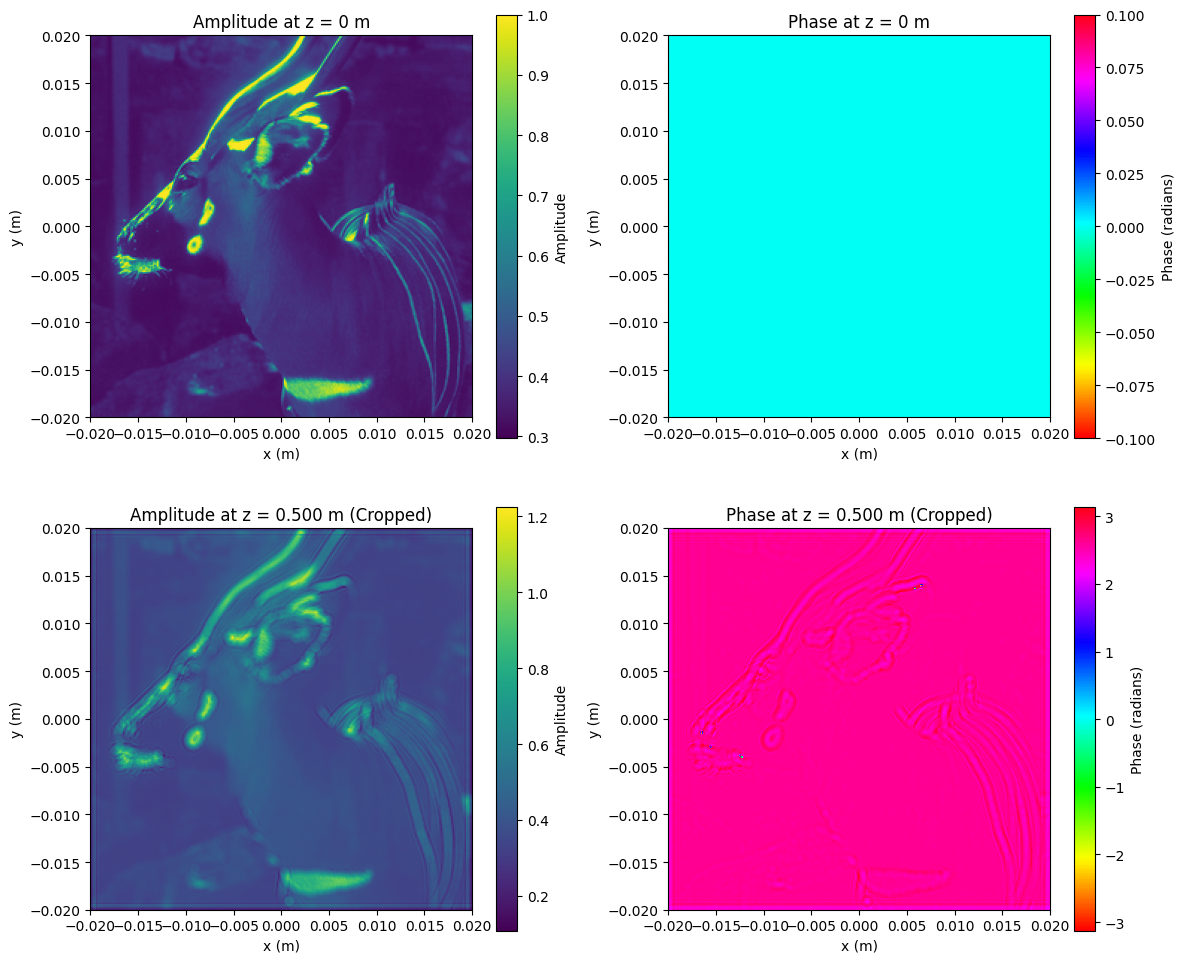

At z = 0 mm:
Max amplitude: 1.000
Min amplitude: 0.297
Phase range: 0.000 to 0.000 radians

At z = 500 mm (Cropped):
Max amplitude: 1.224
Min amplitude: 0.108
Phase range: -3.127 to 3.138 radians


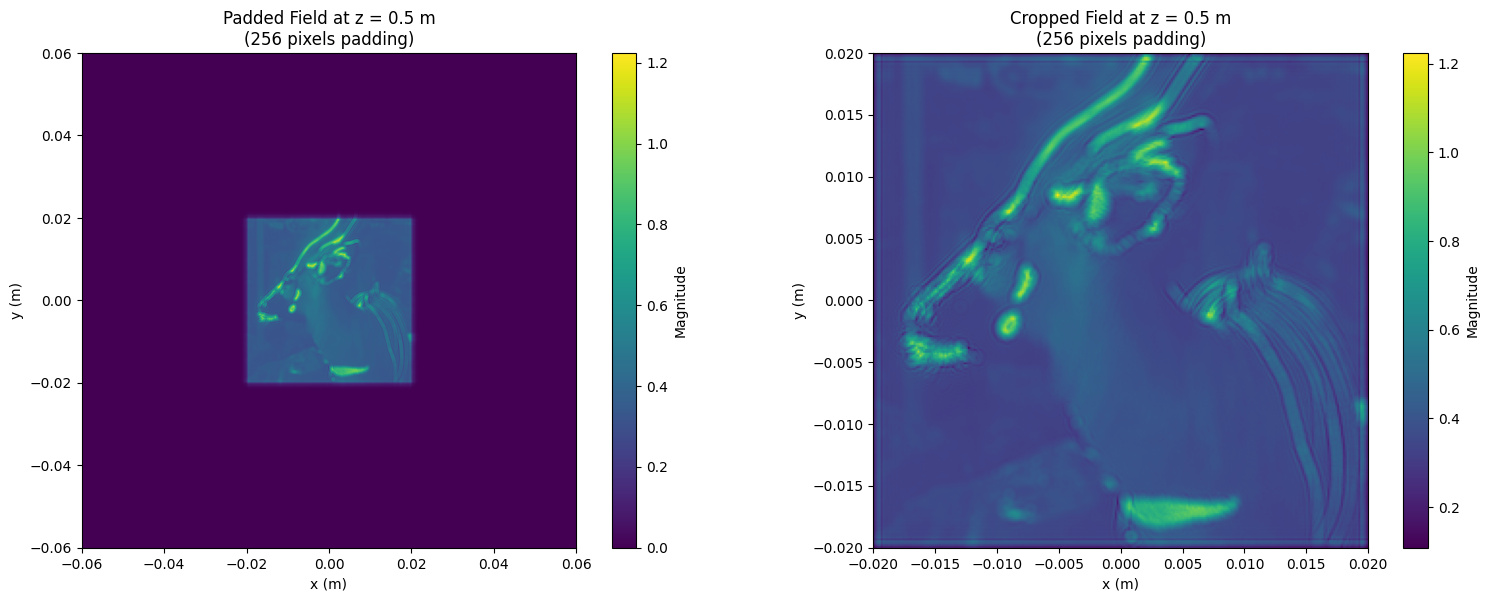

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.image as mpimg
from PIL import Image

def angular_spectrum_propagation(E0, wavelength, z, xmax, N, padding_pixels=0):
    """Calculate electric field propagation with optional padding, returning both padded and cropped fields"""
    # If padding is requested, extend the field
    if padding_pixels > 0:
        N_padded = N + 2 * padding_pixels
        E0_padded = np.zeros((N_padded, N_padded), dtype=complex)
        start_idx = padding_pixels
        end_idx = padding_pixels + N
        E0_padded[start_idx:end_idx, start_idx:end_idx] = E0
        input_field = E0_padded
        total_N = N_padded
        total_xmax = xmax * (N_padded / N)  # Adjust domain size proportionally
    else:
        input_field = E0
        total_N = N
        total_xmax = xmax
    
    # Propagation
    dx = 2 * total_xmax / total_N
    x = np.linspace(-total_xmax, total_xmax, total_N, endpoint=False)
    X, Y = np.meshgrid(x, x)
    
    k = 2 * np.pi / wavelength
    fx = np.fft.fftfreq(total_N, dx)
    FX, FY = np.meshgrid(fx, fx)
    
    kx = 2 * np.pi * FX
    ky = 2 * np.pi * FY
    kz = np.sqrt(k**2 - kx**2 - ky**2)
    kz = np.real(kz) * (kz.imag == 0)  # Avoid complex values outside evanescent region
    H = np.exp(1j * kz * z)
    H[kx**2 + ky**2 > k**2] = 0  # Set evanescent waves to zero
    
    U0 = fft2(input_field)  # No fftshift needed with fftfreq
    U = U0 * H
    E = ifft2(U)
    
    # Calculate amplitude and phase for padded field
    mag_padded = np.abs(E)
    phase_padded = np.angle(E)
    
    # Coordinates for padded field
    X_padded = X
    Y_padded = Y
    
    # Remove padding from the output if it was applied
    if padding_pixels > 0:
        mag_cropped = mag_padded[start_idx:end_idx, start_idx:end_idx]
        phase_cropped = phase_padded[start_idx:end_idx, start_idx:end_idx]
        X_cropped = X[start_idx:end_idx, start_idx:end_idx]
        Y_cropped = Y[start_idx:end_idx, start_idx:end_idx]
    else:
        mag_cropped = mag_padded
        phase_cropped = phase_padded
        X_cropped = X
        Y_cropped = Y
    
    return (mag_padded, phase_padded, X_padded, Y_padded), (mag_cropped, phase_cropped, X_cropped, Y_cropped)

def propagate_field(padding_pixels, resized_array):
    # Parameters
    lambda_ = 633e-9  # wavelength in meters (633 nm)
    xmax = 2e-2       # 2 cm in meters (field width)
    z = 500e-3        # propagation distance 500 mm in meters
    N = 256           # image size (256x256)

    # Convert to 2D array and set as amplitude
    if resized_array.ndim == 3:
        field = np.mean(resized_array, axis=2)  # Average color channels if RGB
    else:
        field = resized_array

    field = field.astype(np.float64)

    # Normalize field to maximum amplitude of 1
    field = field / np.max(field)

    # Initial phase (flat, set to 0)
    phase = np.zeros((N, N))
    u0 = field * np.exp(1j * phase)  # complex field

    # Calculate initial amplitude and phase
    amplitude0 = np.abs(u0)
    phase0 = np.angle(u0)

    # Propagate the field
    (mag_padded, phase_padded, X_padded, Y_padded), (mag_cropped, phase_cropped, X_cropped, Y_cropped) = \
        angular_spectrum_propagation(u0, lambda_, z, xmax, N, padding_pixels)

    # Plot results
    plt.figure(figsize=(12, 10))

    # Initial field (z = 0)
    plt.subplot(221)
    plt.imshow(amplitude0, extent=[-xmax, xmax, -xmax, xmax])
    plt.title('Amplitude at z = 0 m')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.colorbar(label='Amplitude')

    plt.subplot(222)
    plt.imshow(phase0, extent=[-xmax, xmax, -xmax, xmax], cmap='hsv')
    plt.title('Phase at z = 0 m')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.colorbar(label='Phase (radians)')

    # Propagated field (z = 500 mm, cropped)
    plt.subplot(223)
    plt.imshow(mag_cropped, extent=[-xmax, xmax, -xmax, xmax])
    plt.title('Amplitude at z = 0.500 m (Cropped)')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.colorbar(label='Amplitude')

    plt.subplot(224)
    plt.imshow(phase_cropped, extent=[-xmax, xmax, -xmax, xmax], cmap='hsv')
    plt.title('Phase at z = 0.500 m (Cropped)')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.colorbar(label='Phase (radians)')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("At z = 0 mm:")
    print(f"Max amplitude: {np.max(amplitude0):.3f}")
    print(f"Min amplitude: {np.min(amplitude0):.3f}")
    print(f"Phase range: {np.min(phase0):.3f} to {np.max(phase0):.3f} radians")
    print("\nAt z = 500 mm (Cropped):")
    print(f"Max amplitude: {np.max(mag_cropped):.3f}")
    print(f"Min amplitude: {np.min(mag_cropped):.3f}")
    print(f"Phase range: {np.min(phase_cropped):.3f} to {np.max(phase_cropped):.3f} radians")

        # Plot 1: 2D Output Field Magnitude (Padded vs Cropped)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    im1 = ax1.imshow(mag_padded, extent=[-xmax * (mag_padded.shape[1] / N), xmax * (mag_padded.shape[1] / N),
                                         -xmax * (mag_padded.shape[0] / N), xmax * (mag_padded.shape[0] / N)], cmap='viridis')
    ax1.set_title(f'Padded Field at z = {z} m\n({padding_pixels} pixels padding)')
    ax1.set_xlabel('x (m)')
    ax1.set_ylabel('y (m)')
    plt.colorbar(im1, ax=ax1, label='Magnitude')
    
    im2 = ax2.imshow(mag_cropped, extent=[-xmax, xmax, -xmax, xmax], cmap='viridis')
    ax2.set_title(f'Cropped Field at z = {z} m\n({padding_pixels} pixels padding)')
    ax2.set_xlabel('x (m)')
    ax2.set_ylabel('y (m)')
    plt.colorbar(im2, ax=ax2, label='Magnitude')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":

    # Padding calculation
    N = 256
    xmax = 2e-2  # 2 cm
    dx = xmax / N  # Grid spacing: ~7.8125e-5 m per pixel
    desired_padding_pixels_per_side = 256  # 256 pixels per side
    padding_distance_per_side = dx * desired_padding_pixels_per_side  # ~0.02 m per side
    print(f"Padded extra {padding_distance_per_side*100:.3f} cm per side ({desired_padding_pixels_per_side} pixels)")
    
    # Run propagation
    propagate_field(padding_pixels=desired_padding_pixels_per_side, resized_array=resized_array)

Padded extra 2.000 cm per side (256 pixels)


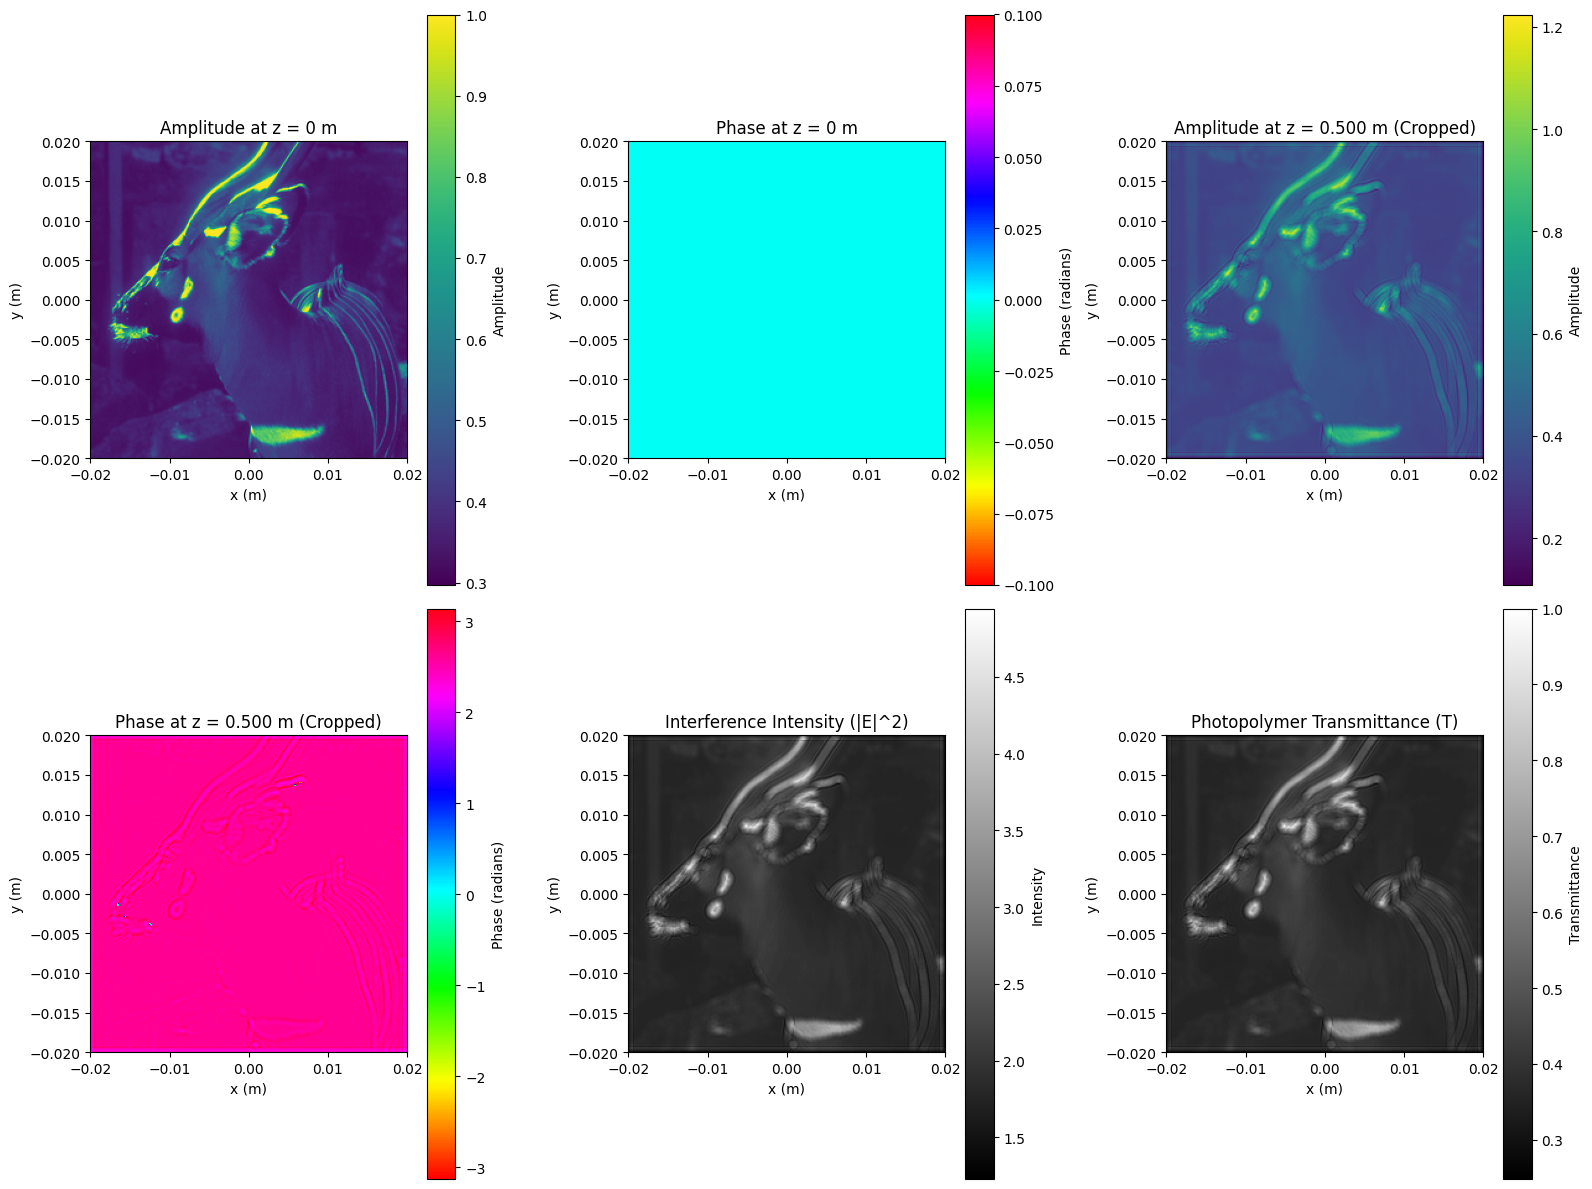

At z = 0 mm:
Max amplitude: 1.000
Min amplitude: 0.297
Phase range: 0.000 to 0.000 radians

At z = 500 mm (Cropped):
Max amplitude: 1.224
Min amplitude: 0.108
Phase range: -3.127 to 3.138 radians

Interference Pattern:
Max intensity: 4.946
Min intensity: 1.229

Photopolymer Transmittance:
Max: 1.000 (normalized)
Min: 0.248 (normalized)


In [38]:
## c 
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.image as mpimg
from PIL import Image

def angular_spectrum_propagation(E0, wavelength, z, xmax, N, padding_pixels=0):
    """Calculate electric field propagation with optional padding, returning both padded and cropped fields"""
    # If padding is requested, extend the field
    if padding_pixels > 0:
        N_padded = N + 2 * padding_pixels
        E0_padded = np.zeros((N_padded, N_padded), dtype=complex)
        start_idx = padding_pixels
        end_idx = padding_pixels + N
        E0_padded[start_idx:end_idx, start_idx:end_idx] = E0
        input_field = E0_padded
        total_N = N_padded
        total_xmax = xmax * (N_padded / N)  # Adjust domain size proportionally
    else:
        input_field = E0
        total_N = N
        total_xmax = xmax
    
    # Propagation
    dx = 2 * total_xmax / total_N
    x = np.linspace(-total_xmax, total_xmax, total_N, endpoint=False)
    X, Y = np.meshgrid(x, x)
    
    k = 2 * np.pi / wavelength
    fx = np.fft.fftfreq(total_N, dx)
    FX, FY = np.meshgrid(fx, fx)
    
    kx = 2 * np.pi * FX
    ky = 2 * np.pi * FY
    kz = np.sqrt(k**2 - kx**2 - ky**2)
    kz = np.real(kz) * (kz.imag == 0)  # Avoid complex values outside evanescent region
    H = np.exp(1j * kz * z)
    H[kx**2 + ky**2 > k**2] = 0  # Set evanescent waves to zero
    
    U0 = fft2(input_field)  # No fftshift needed with fftfreq
    U = U0 * H
    E = ifft2(U)
    
    # Calculate amplitude and phase for padded field
    mag_padded = np.abs(E)
    phase_padded = np.angle(E)
    
    # Coordinates for padded field
    X_padded = X
    Y_padded = Y
    
    # Remove padding from the output if it was applied
    if padding_pixels > 0:
        mag_cropped = mag_padded[start_idx:end_idx, start_idx:end_idx]
        phase_cropped = phase_padded[start_idx:end_idx, start_idx:end_idx]
        X_cropped = X[start_idx:end_idx, start_idx:end_idx]
        Y_cropped = Y[start_idx:end_idx, start_idx:end_idx]
    else:
        mag_cropped = mag_padded
        phase_cropped = phase_padded
        X_cropped = X
        Y_cropped = Y
    
    return (mag_padded, phase_padded, X_padded, Y_padded), (mag_cropped, phase_cropped, X_cropped, Y_cropped)

def propagate_field_and_interference(padding_pixels, resized_array):
    # Parameters
    lambda_ = 633e-9  # wavelength in meters (633 nm)
    xmax = 2e-2       # 2 cm in meters (field width)
    z = 500e-3        # propagation distance 500 mm in meters
    N = 256           # image size (256x256)

    # Convert to 2D array and set as amplitude
    if resized_array.ndim == 3:
        field = np.mean(resized_array, axis=2)  # Average color channels if RGB
    else:
        field = resized_array

    field = field.astype(np.float64)

    # Normalize field to maximum amplitude of 1
    field = field / np.max(field)

    # Initial phase (flat, set to 0)
    phase = np.zeros((N, N))
    u0 = field * np.exp(1j * phase)  # complex initial field

    # Calculate initial amplitude and phase
    amplitude0 = np.abs(u0)
    phase0 = np.angle(u0)

    # Propagate the field
    (mag_padded, phase_padded, X_padded, Y_padded), (mag_cropped, phase_cropped, X_cropped, Y_cropped) = \
        angular_spectrum_propagation(u0, lambda_, z, xmax, N, padding_pixels)

    # Reconstruct the complex propagated field (E0) from amplitude and phase
    E0 = mag_cropped * np.exp(1j * phase_cropped)

    # Step 1: Interference with a unit-amplitude plane wave (reference beam)
    E_interference = 1 + E0  # Complex field: 1 (reference) + E0 (object)

    # Step 2: Calculate intensity (squared magnitude)
    I_interference = np.abs(E_interference) ** 2

    # Step 3: Calculate photopolymer transmittance (normalized intensity)
    T = I_interference / np.max(I_interference)

    # Plot results
    plt.figure(figsize=(16, 12))

    # Initial field (z = 0)
    plt.subplot(231)
    plt.imshow(amplitude0, extent=[-xmax, xmax, -xmax, xmax])
    plt.title('Amplitude at z = 0 m')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.colorbar(label='Amplitude')

    plt.subplot(232)
    plt.imshow(phase0, extent=[-xmax, xmax, -xmax, xmax], cmap='hsv')
    plt.title('Phase at z = 0 m')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.colorbar(label='Phase (radians)')

    # Propagated field (z = 500 mm, cropped)
    plt.subplot(233)
    plt.imshow(mag_cropped, extent=[-xmax, xmax, -xmax, xmax])
    plt.title('Amplitude at z = 0.500 m (Cropped)')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.colorbar(label='Amplitude')

    plt.subplot(234)
    plt.imshow(phase_cropped, extent=[-xmax, xmax, -xmax, xmax], cmap='hsv')
    plt.title('Phase at z = 0.500 m (Cropped)')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.colorbar(label='Phase (radians)')

    # Interference pattern intensity
    plt.subplot(235)
    plt.imshow(I_interference, extent=[-xmax, xmax, -xmax, xmax], cmap='gray')
    plt.title('Interference Intensity (|E|^2)')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.colorbar(label='Intensity')

    # Photopolymer transmittance
    plt.subplot(236)
    plt.imshow(T, extent=[-xmax, xmax, -xmax, xmax], cmap='gray')
    plt.title('Photopolymer Transmittance (T)')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.colorbar(label='Transmittance')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("At z = 0 mm:")
    print(f"Max amplitude: {np.max(amplitude0):.3f}")
    print(f"Min amplitude: {np.min(amplitude0):.3f}")
    print(f"Phase range: {np.min(phase0):.3f} to {np.max(phase0):.3f} radians")
    print("\nAt z = 500 mm (Cropped):")
    print(f"Max amplitude: {np.max(mag_cropped):.3f}")
    print(f"Min amplitude: {np.min(mag_cropped):.3f}")
    print(f"Phase range: {np.min(phase_cropped):.3f} to {np.max(phase_cropped):.3f} radians")
    print("\nInterference Pattern:")
    print(f"Max intensity: {np.max(I_interference):.3f}")
    print(f"Min intensity: {np.min(I_interference):.3f}")
    print("\nPhotopolymer Transmittance:")
    print(f"Max: {np.max(T):.3f} (normalized)")
    print(f"Min: {np.min(T):.3f} (normalized)")

if __name__ == "__main__":
    # Load and resize the image (assuming deer.png exists)
    img = mpimg.imread('deer.png')
    
    # Convert to PIL Image for resizing
    pil_img = Image.fromarray(np.uint8(img * 255) if img.max() <= 1 else img)
    
    # Resize to 256x256
    resized_array = np.array(pil_img.resize((256, 256), Image.Resampling.LANCZOS))

    # Padding calculation
    N = 256
    xmax = 2e-2  # 2 cm
    dx = xmax / N  # Grid spacing: ~7.8125e-5 m per pixel
    desired_padding_pixels_per_side = 256  # 256 pixels per side
    padding_distance_per_side = dx * desired_padding_pixels_per_side  # ~0.02 m per side
    print(f"Padded extra {padding_distance_per_side*100:.3f} cm per side ({desired_padding_pixels_per_side} pixels)")
    
    # Run propagation and interference calculation
    propagate_field_and_interference(padding_pixels=desired_padding_pixels_per_side, resized_array=resized_array)

Padded extra 2.000 cm per side (256 pixels)


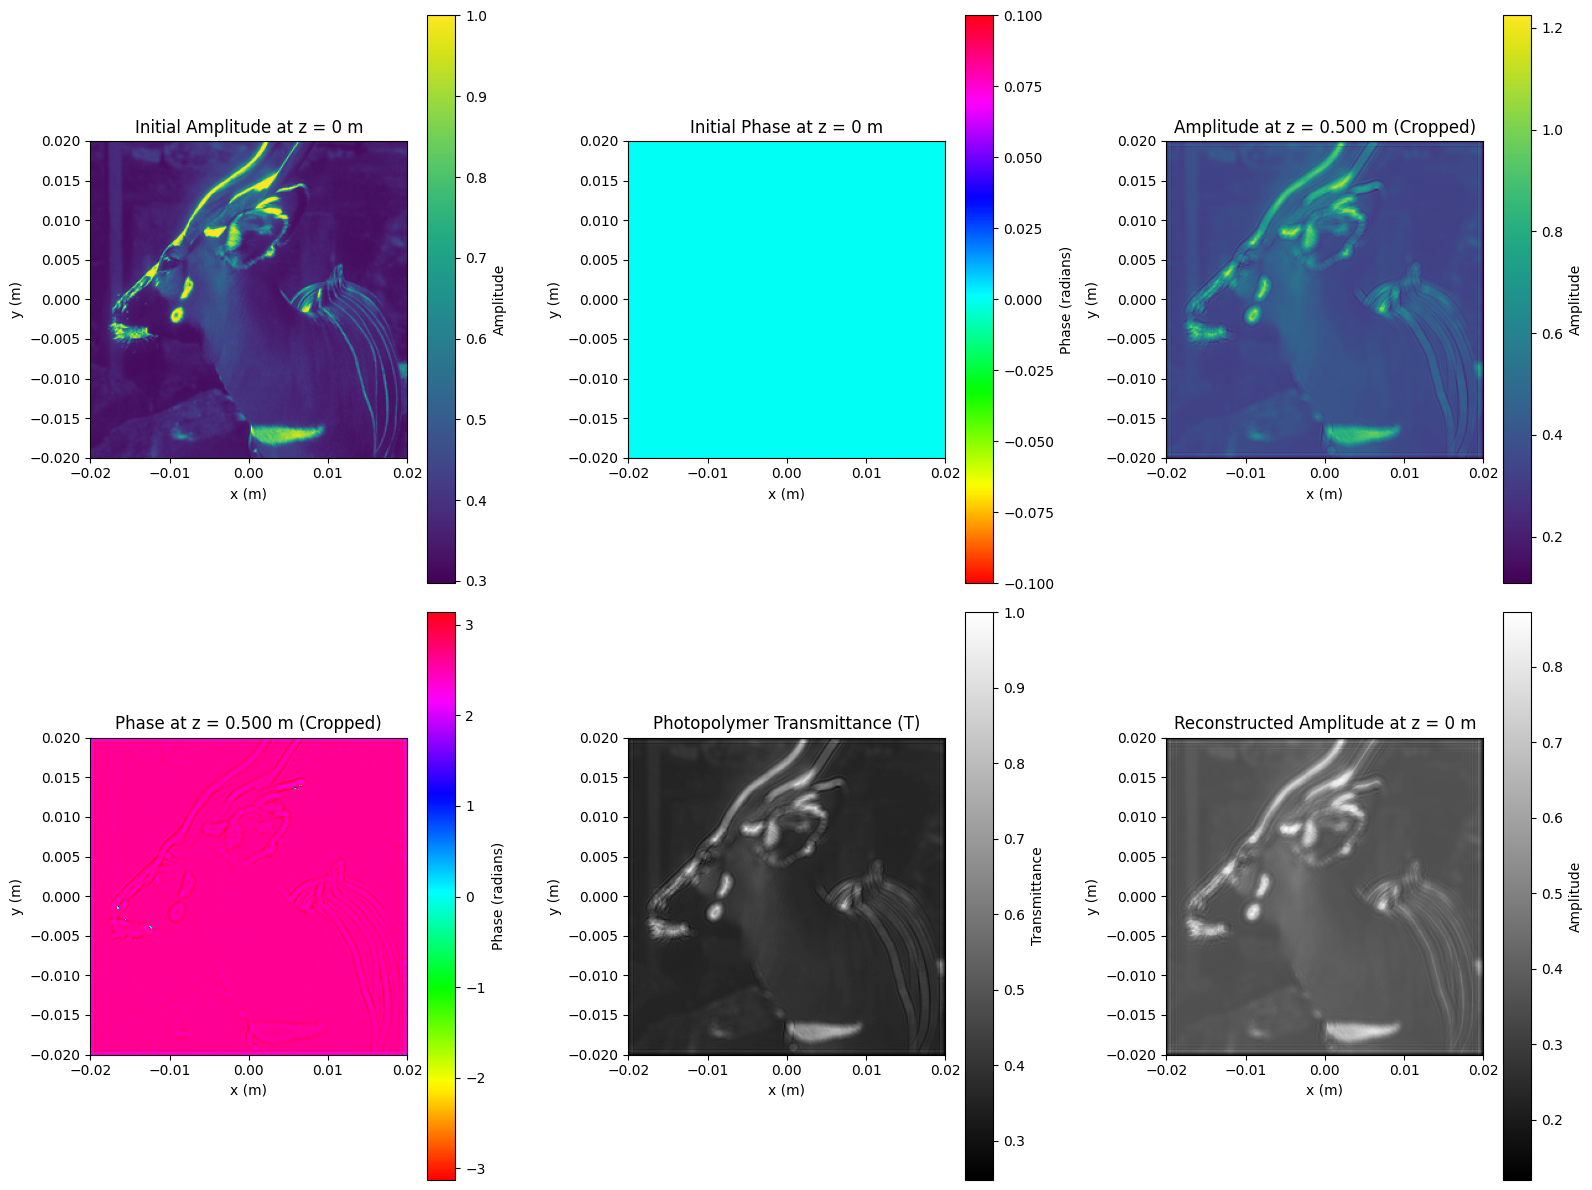

At z = 0 mm (Initial):
Max amplitude: 1.000
Min amplitude: 0.297
Phase range: 0.000 to 0.000 radians

At z = 500 mm (Cropped):
Max amplitude: 1.224
Min amplitude: 0.108
Phase range: -3.127 to 3.138 radians

Photopolymer Transmittance:
Max: 1.000 (normalized)
Min: 0.248 (normalized)

Reconstructed Field at z = 0 mm:
Max amplitude: 0.872
Min amplitude: 0.120

Correlation between initial and reconstructed amplitude: 0.921
The reconstructed field looks similar to the original object (deer).


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.image as mpimg
from PIL import Image

def angular_spectrum_propagation(E0, wavelength, z, xmax, N, padding_pixels=0):
    """Calculate electric field propagation with optional padding, returning both padded and cropped fields"""
    # If padding is requested, extend the field
    if padding_pixels > 0:
        N_padded = N + 2 * padding_pixels
        E0_padded = np.zeros((N_padded, N_padded), dtype=complex)
        start_idx = padding_pixels
        end_idx = padding_pixels + N
        E0_padded[start_idx:end_idx, start_idx:end_idx] = E0
        input_field = E0_padded
        total_N = N_padded
        total_xmax = xmax * (N_padded / N)  # Adjust domain size proportionally
    else:
        input_field = E0
        total_N = N
        total_xmax = xmax
    
    # Propagation
    dx = 2 * total_xmax / total_N
    x = np.linspace(-total_xmax, total_xmax, total_N, endpoint=False)
    X, Y = np.meshgrid(x, x)
    
    k = 2 * np.pi / wavelength
    fx = np.fft.fftfreq(total_N, dx)
    FX, FY = np.meshgrid(fx, fx)
    
    kx = 2 * np.pi * FX
    ky = 2 * np.pi * FY
    kz = np.sqrt(k**2 - kx**2 - ky**2)
    kz = np.real(kz) * (kz.imag == 0)  # Avoid complex values outside evanescent region
    H = np.exp(1j * kz * z)
    H[kx**2 + ky**2 > k**2] = 0  # Set evanescent waves to zero
    
    U0 = fft2(input_field)  # No fftshift needed with fftfreq
    U = U0 * H
    E = ifft2(U)
    
    # Calculate amplitude and phase for padded field
    mag_padded = np.abs(E)
    phase_padded = np.angle(E)
    
    # Coordinates for padded field
    X_padded = X
    Y_padded = Y
    
    # Remove padding from the output if it was applied
    if padding_pixels > 0:
        mag_cropped = mag_padded[start_idx:end_idx, start_idx:end_idx]
        phase_cropped = phase_padded[start_idx:end_idx, start_idx:end_idx]
        X_cropped = X[start_idx:end_idx, start_idx:end_idx]
        Y_cropped = Y[start_idx:end_idx, start_idx:end_idx]
    else:
        mag_cropped = mag_padded
        phase_cropped = phase_padded
        X_cropped = X
        Y_cropped = Y
    
    return (mag_padded, phase_padded, X_padded, Y_padded), (mag_cropped, phase_cropped, X_cropped, Y_cropped)

def propagate_field_and_reconstruction(padding_pixels, resized_array):
    # Parameters
    lambda_ = 633e-9  # wavelength in meters (633 nm)
    xmax = 2e-2       # 2 cm in meters (field width)
    z = 500e-3        # propagation distance 500 mm in meters
    N = 256           # image size (256x256)

    # Convert to 2D array and set as amplitude
    if resized_array.ndim == 3:
        field = np.mean(resized_array, axis=2)  # Average color channels if RGB
    else:
        field = resized_array

    field = field.astype(np.float64)

    # Normalize field to maximum amplitude of 1
    field = field / np.max(field)

    # Initial phase (flat, set to 0)
    phase = np.zeros((N, N))
    u0 = field * np.exp(1j * phase)  # complex initial field

    # Calculate initial amplitude and phase
    amplitude0 = np.abs(u0)
    phase0 = np.angle(u0)

    # Propagate the field forward 500 mm
    (mag_padded, phase_padded, X_padded, Y_padded), (mag_cropped, phase_cropped, X_cropped, Y_cropped) = \
        angular_spectrum_propagation(u0, lambda_, z, xmax, N, padding_pixels)

    # Use mag_cropped as E0 (amplitude at z = 500 mm, part b)
    E0 = mag_cropped  # Amplitude of the propagated field (no phase, as it's the recorded intensity)

    # Step 1: Interference with reference beam (from previous step, but now we use T for reconstruction)
    # Calculate interference pattern intensity (from previous step, using E0 for photopolymer recording)
    E_interference = 1 + (E0 * np.exp(1j * 0))  # Assume flat phase for E0 (amplitude only)
    I_interference = np.abs(E_interference) ** 2
    T = I_interference / np.max(I_interference)  # Photopolymer transmittance

    # Step 2: Reconstruction beam - Unit-amplitude plane wave traveling in opposite direction
    # The photopolymer modulates the reconstruction beam: E(x, y) = T(x, y) (amplitude only, flat phase)
    E_reconstruction = T * np.exp(1j * 0)  # Unit amplitude modulated by T, flat phase

    # Step 3: Propagate this field back 500 mm (z = -500 mm) to the starting plane (z = 0)
    (mag_padded_back, phase_padded_back, X_padded_back, Y_padded_back), (mag_cropped_back, phase_cropped_back, X_cropped_back, Y_cropped_back) = \
        angular_spectrum_propagation(E_reconstruction, lambda_, -z, xmax, N, padding_pixels)

    # The reconstructed field amplitude is the magnitude of the cropped field at z = 0
    amplitude_reconstructed = mag_cropped_back

    # Plot results
    plt.figure(figsize=(16, 12))

    # Initial field (z = 0)
    plt.subplot(231)
    plt.imshow(amplitude0, extent=[-xmax, xmax, -xmax, xmax])
    plt.title('Initial Amplitude at z = 0 m')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.colorbar(label='Amplitude')

    plt.subplot(232)
    plt.imshow(phase0, extent=[-xmax, xmax, -xmax, xmax], cmap='hsv')
    plt.title('Initial Phase at z = 0 m')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.colorbar(label='Phase (radians)')

    # Propagated field (z = 500 mm, cropped)
    plt.subplot(233)
    plt.imshow(mag_cropped, extent=[-xmax, xmax, -xmax, xmax])
    plt.title('Amplitude at z = 0.500 m (Cropped)')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.colorbar(label='Amplitude')

    plt.subplot(234)
    plt.imshow(phase_cropped, extent=[-xmax, xmax, -xmax, xmax], cmap='hsv')
    plt.title('Phase at z = 0.500 m (Cropped)')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.colorbar(label='Phase (radians)')

    # Photopolymer transmittance (used to modulate reconstruction beam)
    plt.subplot(235)
    plt.imshow(T, extent=[-xmax, xmax, -xmax, xmax], cmap='gray')
    plt.title('Photopolymer Transmittance (T)')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.colorbar(label='Transmittance')

    # Reconstructed field amplitude (back-propagated to z = 0)
    plt.subplot(236)
    plt.imshow(amplitude_reconstructed, extent=[-xmax, xmax, -xmax, xmax], cmap='gray')
    plt.title('Reconstructed Amplitude at z = 0 m')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.colorbar(label='Amplitude')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("At z = 0 mm (Initial):")
    print(f"Max amplitude: {np.max(amplitude0):.3f}")
    print(f"Min amplitude: {np.min(amplitude0):.3f}")
    print(f"Phase range: {np.min(phase0):.3f} to {np.max(phase0):.3f} radians")
    print("\nAt z = 500 mm (Cropped):")
    print(f"Max amplitude: {np.max(mag_cropped):.3f}")
    print(f"Min amplitude: {np.min(mag_cropped):.3f}")
    print(f"Phase range: {np.min(phase_cropped):.3f} to {np.max(phase_cropped):.3f} radians")
    print("\nPhotopolymer Transmittance:")
    print(f"Max: {np.max(T):.3f} (normalized)")
    print(f"Min: {np.min(T):.3f} (normalized)")
    print("\nReconstructed Field at z = 0 mm:")
    print(f"Max amplitude: {np.max(amplitude_reconstructed):.3f}")
    print(f"Min amplitude: {np.min(amplitude_reconstructed):.3f}")

    # Confirm similarity to the original object
    correlation = np.corrcoef(amplitude0.flatten(), amplitude_reconstructed.flatten())[0, 1]
    print(f"\nCorrelation between initial and reconstructed amplitude: {correlation:.3f}")
    if correlation > 0.7:  # Arbitrary threshold for similarity
        print("The reconstructed field looks similar to the original object (deer).")
    else:
        print("The reconstructed field does not closely resemble the original object.")

if __name__ == "__main__":
    # Load and resize the image (assuming deer.png exists)
    img = mpimg.imread('deer.png')
    
    # Convert to PIL Image for resizing
    pil_img = Image.fromarray(np.uint8(img * 255) if img.max() <= 1 else img)
    
    # Resize to 256x256
    resized_array = np.array(pil_img.resize((256, 256), Image.Resampling.LANCZOS))

    # Padding calculation
    N = 256
    xmax = 2e-2  # 2 cm
    dx = xmax / N  # Grid spacing: ~7.8125e-5 m per pixel
    desired_padding_pixels_per_side = 256  # 256 pixels per side
    padding_distance_per_side = dx * desired_padding_pixels_per_side  # ~0.02 m per side
    print(f"Padded extra {padding_distance_per_side*100:.3f} cm per side ({desired_padding_pixels_per_side} pixels)")
    
    # Run propagation, interference, and reconstruction
    propagate_field_and_reconstruction(padding_pixels=desired_padding_pixels_per_side, resized_array=resized_array)